In [1]:
import onc
import helpers_reworked as my_functions

import pandas as pd
from functools import reduce # used for dataframes

import os
# token = os.environ["GRACE_TOKEN"]
from dotenv import load_dotenv
load_dotenv()
token = os.getenv("ONC_TOKEN")



1. Define your parameters
2. Request data
3. Extract data and place in a dataframe
* Process
4. Plot 


TODO: transform these into readable tables

Schema: deviceCategoryCode {[propertyCode: str, name: str, unit: str]}
"OXYSENSOR": [{"propertyCode": "oxygen", "name": "Oxygen", "unit": "ml/l"}],
"radiometer": [{"propertyCode": "parphotonbased", "name": "PAR", "unit": "µmol/m²/s" }],
"FLNTU": [{"propertyCode": "chlorophyll", "name": "Chlorophyll", "unit": "µg/l"}, 
            {"propertyCode": "turbidityntu", "name": "Turbidity", "unit": "NTU"}],
"CTD": [{"propertyCode": "conductivity", "name": "Conductivity", "unit": "S/m"}, 
        {"propertyCode": "seawatertemperature", "name": "Temperature", "unit": "°C"},
        {"propertyCode": "density", "name": "Density", "unit": "kg/m3"}],


place = {
    "FGPPN": {
        "name": "Folger Pinnacle",
        "mountCode": "FGPPN",
        "castCode":"CF341",
        "mountDepth": 23,
        "depthThreshold": 20 # depth to be considered for deep section
    },
    "FGPD": {
        "name": "Folger Deep",
        "mountCode": "FGPD",
        "castCode": "CF340",
        "mountDepth": 90,
        "depthThreshold": 85
    }
}
    

# Example

                                  conductivity      density  temperature
timestamp                                                               
2021-01-01 00:00:00.863000+00:00       3.19625  1022.858180       9.1893
2021-01-01 00:00:01.862000+00:00       3.19646  1022.860568       9.1889
2021-01-01 00:00:02.863000+00:00       3.19676  1022.863523       9.1890
2021-01-01 00:00:03.864000+00:00       3.19658  1022.862239       9.1891
2021-01-01 00:00:04.862000+00:00       3.19636  1022.860159       9.1891


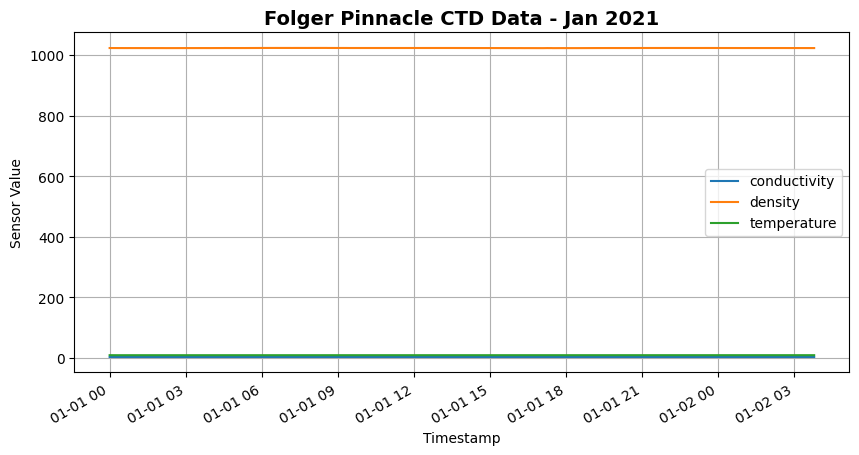

In [2]:
# EXAMPLE - FOLGER DEEP - CTD - JAN 2021

import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from onc import ONC  # ONC Python API client

# 1. Connect to ONC API using your token
my_onc = ONC(token=token)  # Replace with your actual token

# 2. Define query parameters for Folger Pinnacle CTD data (Jan 2021)
query_params = {
    "locationCode": "FGPPN",  # Folger Pinnacle
    "deviceCategoryCode": "CTD",
    "propertyCode": "conductivity,seawatertemperature,density",
    "dateFrom": "2021-01-01T00:00:00.000Z",
    "dateTo": "2021-02-01T00:00:00.000Z"
}

# 3. Request scalar data from ONC
json_response = my_onc.getScalardata(query_params)

# 4. Convert JSON response to a list of individual sensor DataFrames
sensor_dataframes = []
for sensor_entry in json_response["sensorData"]:
    parameter = sensor_entry["sensorCategoryCode"]               # e.g. "seawatertemperature"
    timestamps = sensor_entry["data"]["sampleTimes"]             # Time values
    readings = sensor_entry["data"]["values"]                    # Corresponding measurements

    df = pd.DataFrame({
        "timestamp": pd.to_datetime(timestamps),
        parameter: readings
    })
    sensor_dataframes.append(df)

# 5. Merge all sensor DataFrames on timestamp
ctd_dataframe = reduce(lambda left, right: pd.merge(left, right, on="timestamp", how="outer"), sensor_dataframes)

# 6. Sort dataframe by time and set timestamp as the index
ctd_dataframe.sort_values("timestamp", inplace=True)
ctd_dataframe.set_index("timestamp", inplace=True)

# 7. Preview the cleaned dataset
print(ctd_dataframe.head())

# 8. Plot CTD sensor values over time using matplotlib

# Define figure and axes
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)

# Plot each sensor property on the same axes
ctd_dataframe.plot(ax=ax)

# Customize the plot
ax.set_title("Folger Pinnacle CTD Data - Jan 2021", fontsize=14, fontweight="bold")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Sensor Value")
ax.grid(True)

plt.show()


# Using Functions
NOTE: mention reducing redudancy

In [3]:
# Define times to use throughout
start_21 = "2021-01-01T00:00:00.000Z"
start_22 = "2022-01-01T00:00:00.000Z"

In [ ]:
# FOLGER DEEP - CTD, OXYGEN SENSOR - 2021 

# 1. generate parameters
deep_21_CTD_params = my_functions.get_device_parameters(start=start_21, end=start_22, locationCode= "FGPD", deviceCategoryCode= "CTD", resample = 1800)
deep_21_ox_parameters = my_functions.get_device_parameters(start=start_21, end=start_22, locationCode="FGPD.O2", deviceCategoryCode= "OXYSENSOR", resample= 1800) # NOTE: 2 ox sensors at FGPD with different location codes

# 2. request data - returned in JSON response
deep_21_CTD_json = my_onc.getScalardata(deep_21_CTD_params)
deep_21_ox_json= my_onc.getScalardata(deep_21_ox_parameters)

# 3. (a) format in dataframe
deep_21_CTD_df = my_functions.get_device_dataframe(result=deep_21_CTD_json, start=start_21, end=start_22, locationCode= "FGPD")
deep_21_ox_df = my_functions.get_device_dataframe(result=deep_21_ox_json, start=start_21, end=start_22, locationCode= "FGPD.02")


Parameters: {'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'propertyCode': 'conductivity,seawatertemperature,density', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
Parameters: {'locationCode': 'FGPD.O2', 'deviceCategoryCode': 'OXYSENSOR', 'sensorCategoryCodes': 'oxygen_corrected', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}


In [ ]:
# FOLGER DEEP - DF: CONDUCTIVITY, TEMPERTURE, DENSITY, OXYGEN - 2021

# 3. (b) combine device data frames
deep_21_all_df = my_functions.merge_device_dataframes(dfs=[deep_21_CTD_df, deep_21_ox_df])

print(deep_21_all_df.head())

# 4. plot data from this dataframe




                           conductivity      density  temperature  \
timestamp                                                           
2021-01-01 00:15:00+00:00      3.447278  1025.020570     9.368090   
2021-01-01 00:45:00+00:00      3.446709  1025.019496     9.362289   
2021-01-01 01:15:00+00:00      3.446169  1025.013739     9.362302   
2021-01-01 01:45:00+00:00      3.445631  1025.008372     9.362097   
2021-01-01 02:15:00+00:00      3.444649  1024.997534     9.364466   

                           oxygen_corrected  
timestamp                                    
2021-01-01 00:15:00+00:00               NaN  
2021-01-01 00:45:00+00:00               NaN  
2021-01-01 01:15:00+00:00               NaN  
2021-01-01 01:45:00+00:00               NaN  
2021-01-01 02:15:00+00:00               NaN  


In [6]:
# FOLGER PINNACLE - CTD, OXYGEN SENSOR, RADIOMETER, FLOUROMETER - 2021 

# generate parameters
pin_21_CTD_params = my_functions.get_device_parameters(start=start_21, end=start_22, locationCode= "FGPPN", deviceCategoryCode= "CTD", resample = 1800)
pin_21_ox_parameters = my_functions.get_device_parameters(start=start_21, end=start_22, locationCode="FGPPN", deviceCategoryCode= "OXYSENSOR", resample= 1800)
pin_21_rad_parameters = my_functions.get_device_parameters(start=start_21, end=start_22, locationCode="FGPPN", deviceCategoryCode= "radiometer", resample= 1800)
pin_21_fl_parameters = my_functions.get_device_parameters(start=start_21, end=start_22, locationCode="FGPPN", deviceCategoryCode= "FLNTU", resample= 1800)

# request data - returned in JSON response
pin_21_CTD_json = my_onc.getScalardata(pin_21_CTD_params)
pin_21_ox_json= my_onc.getScalardata(pin_21_ox_parameters)
pin_21_rad_json= my_onc.getScalardata(pin_21_rad_parameters)
pin_21_fl_json= my_onc.getScalardata(pin_21_fl_parameters)

# format in dataframe
pin_21_CTD_df = my_functions.get_device_dataframe(result=pin_21_CTD_json, start=start_21, end=start_22, locationCode= "FGPPN")
pin_21_ox_df= my_functions.get_device_dataframe(result=pin_21_ox_json, start=start_21, end=start_22, locationCode="FGPPN")
pin_21_rad_df= my_functions.get_device_dataframe(result=pin_21_rad_json, start=start_21, end=start_22, locationCode="FGPPN")
pin_21_fl_df= my_functions.get_device_dataframe(result=pin_21_fl_json, start=start_21, end=start_22, locationCode="FGPPN")

Parameters: {'locationCode': 'FGPPN', 'deviceCategoryCode': 'CTD', 'propertyCode': 'conductivity,seawatertemperature,density', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
Parameters: {'locationCode': 'FGPPN', 'deviceCategoryCode': 'OXYSENSOR', 'sensorCategoryCodes': 'oxygen_corrected', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
Parameters: {'locationCode': 'FGPPN', 'deviceCategoryCode': 'radiometer', 'propertyCode': 'parphotonbased', 'dateFrom': '2021-01-01T00:00:00.000Z', 'dateTo': '2022-01-01T00:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}
Parameters: {'locationCode': 'FGPPN', 'deviceCategoryCode': 'FLNTU', 'propertyCode': 'chlorophyll,turbidityntu', 'dateFrom':

In [7]:
# FOLGER PINNACLE - DF: CONDUCTIVITY, TEMPERTURE, DENSITY, OXYGEN, PAR, CHLOROPHYLL, TURBIDITY - 2021

# combine device data frames
pin_21_all_df = my_functions.merge_device_dataframes(dfs=[pin_21_CTD_df, pin_21_ox_df, pin_21_rad_df, pin_21_fl_df])

print(pin_21_all_df.head())



                           conductivity      density  temperature  \
timestamp                                                           
2021-01-01 00:15:00+00:00      3.181388  1022.789966     9.125013   
2021-01-01 00:45:00+00:00      3.170472  1022.737772     9.079078   
2021-01-01 01:15:00+00:00      3.163149  1022.719933     9.025827   
2021-01-01 01:45:00+00:00      3.161048  1022.705259     9.021572   
2021-01-01 02:15:00+00:00      3.150408  1022.657068     8.973576   

                           oxygen_corrected  \
timestamp                                     
2021-01-01 00:15:00+00:00          6.418278   
2021-01-01 00:45:00+00:00          6.417333   
2021-01-01 01:15:00+00:00          6.372171   
2021-01-01 01:45:00+00:00          6.365439   
2021-01-01 02:15:00+00:00          6.452396   

                           photosynthetically_active_radiation  chlorophyll  \
timestamp                                                                     
2021-01-01 00:15:00+00:00   